# **XGBoost model with the 'inicial' dataset**

In [4]:
import sys
sys.path.append("..") # append the directory above where the databese is.
from utils import config
import pandas as pd
import numpy as np
import sqlite3
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import sklearn
# from numba import jit
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
# %load_ext line_profiler
### disable scientific notation in pandas
pd.set_option('display.float_format', '{:.2f}'.format) ### display up to 2 decimal pts

In [9]:
with sqlite3.connect(config.DATABASE_PATH) as connection:
    df = pd.read_sql("SELECT * FROM CountryIndicators", connection)

In [10]:
def clean_and_pivote(df):
    countries_gdp = df[df["IndicatorCode"] == config.GDP_GROWTH]["CountryCode"].to_list() #countries with gdp
    countries = df["CountryCode"].unique()
    countries_no_gdp = list(set(sorted(countries)) - set(sorted(countries_gdp))) # set difference =  countries with no gdp

    return df.pivot(index=["CountryCode","Year"], columns="IndicatorCode", values="Value").drop(countries_no_gdp)

In [11]:
df_cleaned = clean_and_pivote(df)

In [12]:
df_cleaned.drop(index=range(1960, 1980), level="Year", inplace=True)

### **Correlation matrix**

The correlation matrix is computed to remove the lowest correlated variables with GDP growth, only the 400 more correlated (positively and negatively) remain.

In [13]:
corr = df_cleaned.corr()
corr

IndicatorCode,AG.AGR.TRAC.NO,AG.CON.FERT.PT.ZS,AG.CON.FERT.ZS,AG.LND.AGRI.K2,AG.LND.AGRI.ZS,AG.LND.ARBL.HA,AG.LND.ARBL.HA.PC,AG.LND.ARBL.ZS,AG.LND.CREL.HA,AG.LND.CROP.ZS,...,per_allsp.cov_pop_tot,per_lm_alllm.adq_pop_tot,per_lm_alllm.ben_q1_tot,per_lm_alllm.cov_pop_tot,per_sa_allsa.adq_pop_tot,per_sa_allsa.ben_q1_tot,per_sa_allsa.cov_pop_tot,per_si_allsi.adq_pop_tot,per_si_allsi.ben_q1_tot,per_si_allsi.cov_pop_tot
IndicatorCode,,,,,,,,,,,,,,,,,,,,,
AG.AGR.TRAC.NO,1.00,-0.04,-0.00,0.76,0.00,0.72,0.10,0.01,0.75,-0.09,...,0.26,0.35,0.17,0.51,0.07,0.26,0.10,0.56,-0.06,0.30
AG.CON.FERT.PT.ZS,-0.04,1.00,-0.03,-0.05,-0.06,-0.05,-0.04,-0.03,-0.05,-0.03,...,0.02,0.41,-0.14,-0.14,0.08,0.56,0.09,-0.21,-0.22,-0.20
AG.CON.FERT.ZS,-0.00,-0.03,1.00,-0.04,-0.20,-0.05,-0.13,-0.13,-0.04,-0.02,...,0.28,-0.31,0.14,0.47,-0.09,0.08,0.30,0.10,0.02,0.02
AG.LND.AGRI.K2,0.76,-0.05,-0.04,1.00,0.04,0.79,0.08,-0.06,0.97,-0.12,...,0.01,0.06,-0.18,-0.10,0.03,-0.02,-0.09,0.04,-0.06,0.14
AG.LND.AGRI.ZS,0.00,-0.06,-0.20,0.04,1.00,0.12,0.19,0.55,0.03,0.18,...,0.01,0.45,-0.17,-0.13,0.15,0.20,-0.06,0.08,-0.00,0.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
per_sa_allsa.ben_q1_tot,0.26,0.56,0.08,-0.02,0.20,-0.02,0.09,0.13,-0.03,0.02,...,0.37,-0.03,-0.14,-0.14,-0.02,1.00,0.23,0.26,0.07,0.31
per_sa_allsa.cov_pop_tot,0.10,0.09,0.30,-0.09,-0.06,-0.13,0.04,-0.08,-0.13,-0.16,...,0.87,-0.16,0.33,0.14,-0.11,0.23,1.00,0.22,0.05,0.25
per_si_allsi.adq_pop_tot,0.56,-0.21,0.10,0.04,0.08,0.19,0.13,0.25,0.24,-0.27,...,0.39,0.14,0.09,0.02,0.04,0.26,0.22,1.00,0.08,0.43


In [14]:
max_corr = abs(corr[[config.GDP_GROWTH]]).sort_values(by=[config.GDP_GROWTH], ascending=False)[0:400]
max_corr_vars = list(max_corr.index)
df_corr = df_cleaned.loc[:, max_corr_vars]

In [15]:
df_cleaned = df_corr

In [16]:
df_features = df_cleaned.copy()
df_target = df_cleaned.pop(config.GDP_GROWTH)
df_features.drop(index=2010, level="Year", inplace=True)
df_target.drop(index=1980, level="Year", inplace=True)

To select the imputation method (by mean, by median, by mode, equal to 0, etc) we inspect the distribution of GDP growth.

(0.0, 410.0)

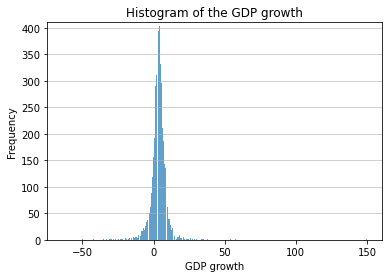

In [18]:
n, bins, patches = plt.hist(x=df_target,
                            bins='auto',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('GDP growth')
plt.ylabel('Frequency')
plt.title('Histogram of the GDP growth')
maxfreq = n.max()
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

 Since it appears to be distributed like a Gaussian, we use the mean to impute the missing values.

In [19]:
X = df_features
y = df_target.to_frame()
print(X.shape)
print(y.shape)
# genereate imputed dataframes by mean
X_imp = X.fillna(X.mean())
X_imp = np.array(X_imp)
y_imp = y.fillna(y.mean())
y_imp = np.array(y_imp)
print(X_imp.shape)
print(y_imp.shape)

(7140, 400)
(7140, 1)
(7140, 400)
(7140, 1)


### **Tunning parameters**

To the selection of the parameters of the first model, different values from *max_depth* and *num_estimators* are analized.

In [130]:
# Tuning parameters
model = xgb.XGBRegressor()
max_depth = [3, 5, 7, 9, 11]
n_estimators = [250, 500, 750, 1000, 1250]
parameters = {'objective':['reg:squarederror'],
              'learning_rate': [.01],
              'max_depth': max_depth,
              'n_estimators': n_estimators,
              'subsample': [.8]}

xgb_grid1 = GridSearchCV(model,
                        parameters,
                        cv = 3,
                        scoring = 'r2',
                        verbose=True,
                        n_jobs=4)

xgb_grid1.fit(X_imp, y_imp)

print(xgb_grid1.best_score_)
print(xgb_grid1.best_params_)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 18.2min
[Parallel(n_jobs=4)]: Done  75 out of  75 | elapsed: 49.0min finished


0.2062123977225231
{'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 1250, 'objective': 'reg:squarederror', 'subsample': 0.8}


Best: 0.206212 using {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 1250, 'objective': 'reg:squarederror', 'subsample': 0.8}
0.140691 (0.016184) with: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 250, 'objective': 'reg:squarederror', 'subsample': 0.8}
0.163966 (0.025614) with: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'objective': 'reg:squarederror', 'subsample': 0.8}
0.172539 (0.028623) with: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 750, 'objective': 'reg:squarederror', 'subsample': 0.8}
0.178434 (0.030266) with: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 1000, 'objective': 'reg:squarederror', 'subsample': 0.8}
0.181300 (0.031046) with: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 1250, 'objective': 'reg:squarederror', 'subsample': 0.8}
0.172906 (0.027881) with: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 250, 'objective': 'reg:squarederror', 'subsample': 0.8}
0.185760 (0.024593) with: {'learning

Text(0, 0.5, 'Scoring')

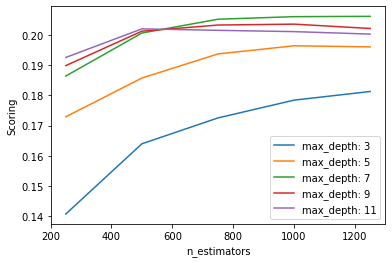

In [131]:
# summarize results
print("Best: %f using %s" % (xgb_grid1.best_score_, xgb_grid1.best_params_))
means = xgb_grid1.cv_results_['mean_test_score']
stds = xgb_grid1.cv_results_['std_test_score']
params = xgb_grid1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

# plot results
scores = np.array(means).reshape(len(n_estimators), len(max_depth))
for i, value in enumerate(max_depth):
    plt.plot(n_estimators, scores[i], label='max_depth: ' + str(value))
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('Scoring')

### **Model with the selected parameters**

Once the "best" parameters are selected, the "first" model is fitted.

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X_imp, y_imp, test_size=0.2, random_state=1)

In [133]:
model = xgb.XGBRegressor(max_depth=7, learning_rate=0.01, subsample=0.8, n_estimators=1250, base_score=y_train.mean())
# model.fit(X_train, y_train, eval_set=[(X_test,y_test)], eval_metric="rmse", verbose=1000, early_stopping_rounds=20)
model.fit(X_train, y_train)
pred = model.predict(X_test, output_margin=True)
print("Model absolute error =", mean_absolute_error(y_test, pred))
print("Model squared error =", mean_squared_error(y_test, pred))
print("R2 =", r2_score(y_test, pred)*100)

Model absolute error = 2.5465251302596688
Model squared error = 22.34353311311342
R2 = 32.04593779880275


With the library shap we obtain the most important variables.

In [134]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

In [135]:
vals = np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(X.columns,vals)),columns=['col_name', 'feature_importance_vals'])
feature_importance

,col_name,feature_importance_vals
0,NY.GDP.MKTP.KD.ZG,1.00
1,NY.GDP.PCAP.KD.ZG,0.09
2,NY.GNP.MKTP.KD.ZG,0.04
3,NY.GNP.PCAP.KD.ZG,0.03
4,NV.IND.TOTL.KD.ZG,0.05
...,...,...
395,NE.GDI.STKB.CD,0.01
396,BN.FIN.TOTL.CD,0.00
397,NY.ADJ.SVNG.CD,0.00
398,TG.VAL.TOTL.GD.ZS,0.02


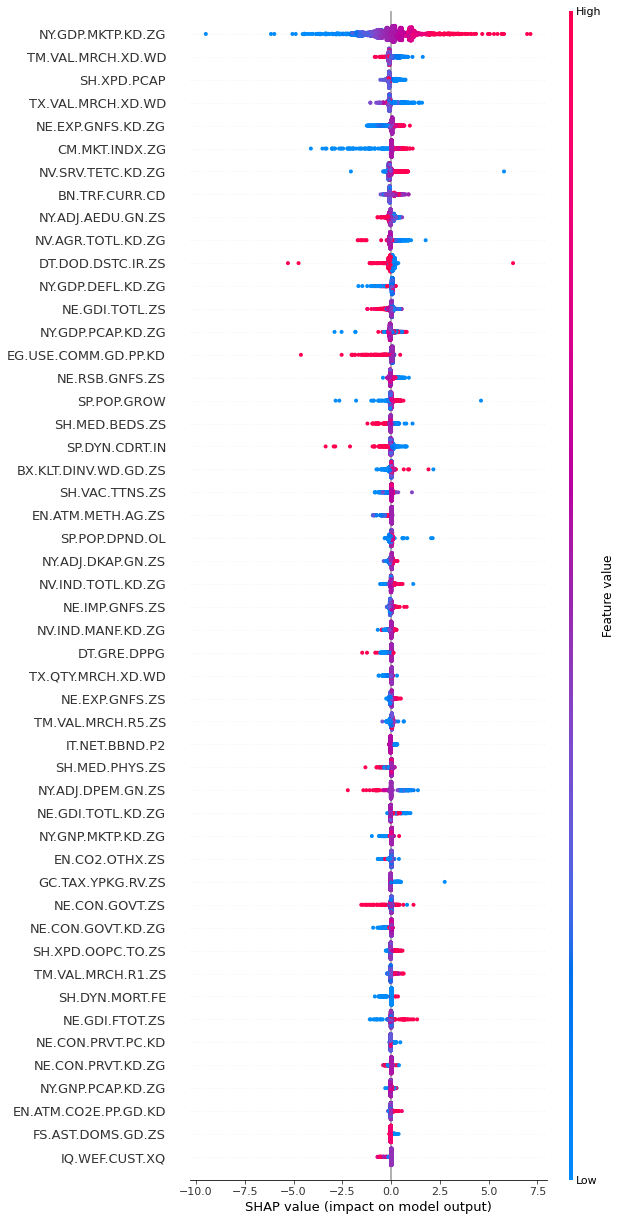

In [136]:
shap.summary_plot(shap_values, X_test, max_display=50, show=False,
                  feature_names=list(feature_importance['col_name']))

## **Features importance selection (50)**

This "first" model is used to choose the 50 variables with more impact on the model output (in the GDP Growth).

In [138]:
feature_importance50 = feature_importance
feature_importance50.sort_values(by=['feature_importance_vals'], ascending=False, inplace=True)
feature_importance50 = feature_importance50[0:50]
feature_importance50
list(feature_importance50['col_name'])

['NY.GDP.MKTP.KD.ZG',
 'TM.VAL.MRCH.XD.WD',
 'SH.XPD.PCAP',
 'TX.VAL.MRCH.XD.WD',
 'NE.EXP.GNFS.KD.ZG',
 'CM.MKT.INDX.ZG',
 'NV.SRV.TETC.KD.ZG',
 'BN.TRF.CURR.CD',
 'NY.ADJ.AEDU.GN.ZS',
 'NV.AGR.TOTL.KD.ZG',
 'DT.DOD.DSTC.IR.ZS',
 'NY.GDP.DEFL.KD.ZG',
 'NE.GDI.TOTL.ZS',
 'NY.GDP.PCAP.KD.ZG',
 'EG.USE.COMM.GD.PP.KD',
 'NE.RSB.GNFS.ZS',
 'SP.POP.GROW',
 'SH.MED.BEDS.ZS',
 'SP.DYN.CDRT.IN',
 'BX.KLT.DINV.WD.GD.ZS',
 'SH.VAC.TTNS.ZS',
 'EN.ATM.METH.AG.ZS',
 'SP.POP.DPND.OL',
 'NY.ADJ.DKAP.GN.ZS',
 'NV.IND.TOTL.KD.ZG',
 'NE.IMP.GNFS.ZS',
 'NV.IND.MANF.KD.ZG',
 'DT.GRE.DPPG',
 'TX.QTY.MRCH.XD.WD',
 'NE.EXP.GNFS.ZS',
 'TM.VAL.MRCH.R5.ZS',
 'IT.NET.BBND.P2',
 'SH.MED.PHYS.ZS',
 'NY.ADJ.DPEM.GN.ZS',
 'NE.GDI.TOTL.KD.ZG',
 'NY.GNP.MKTP.KD.ZG',
 'EN.CO2.OTHX.ZS',
 'GC.TAX.YPKG.RV.ZS',
 'NE.CON.GOVT.ZS',
 'NE.CON.GOVT.KD.ZG',
 'SH.XPD.OOPC.TO.ZS',
 'TM.VAL.MRCH.R1.ZS',
 'SH.DYN.MORT.FE',
 'NE.GDI.FTOT.ZS',
 'NE.CON.PRVT.PC.KD',
 'NE.CON.PRVT.KD.ZG',
 'NY.GNP.PCAP.KD.ZG',
 'EN.ATM.CO2E.PP.GD.KD',
 

In [139]:
df50 = df_features.iloc[:,list(feature_importance50.index)]
df50

IndicatorCode     NY.GDP.MKTP.KD.ZG  TM.VAL.MRCH.XD.WD  SH.XPD.PCAP  \
CountryCode Year                                                      
ABW         1980                nan                nan          nan   
            1981                nan                nan          nan   
            1982                nan                nan          nan   
            1983                nan                nan          nan   
            1984                nan                nan          nan   
...                             ...                ...          ...   
ZWE         2005              -5.71             126.14          nan   
            2006              -3.46             123.46          nan   
            2007              -3.65             136.88          nan   
            2008             -17.67             158.35          nan   
            2009               5.98             155.66          nan   

IndicatorCode     TX.VAL.MRCH.XD.WD  NE.EXP.GNFS.KD.ZG  CM.MKT.INDX.ZG  \
CountryCode Year                                                         
ABW         1980                nan                nan             nan   
            1981                nan                nan             nan   
            1982                nan                nan             nan   
            1983                nan                nan             nan   
            1984                nan                nan             nan   
...                             ...                ...             ...   
ZWE         2005              96.10              -7.34           36.58   
            2006             103.90              -8.94          912.28   
            2007             124.68              -9.79          -83.79   
            2008             114.29             -21.08             nan   
            2009             117.86              -8.27             nan   

IndicatorCode     NV.SRV.TETC.KD.ZG  BN.TRF.CURR.CD  NY.ADJ.AEDU.GN.ZS  \
CountryCode Year                                                         
ABW         1980                nan             nan                nan   
            1981                nan             nan                nan   
            1982                nan             nan                nan   
            1983                nan             nan                nan   
            1984                nan             nan                nan   
...                             ...             ...                ...   
ZWE         2005              -8.46             nan              16.02   
            2006              -2.64             nan              13.30   
            2007              -2.13             nan              10.57   
            2008              -5.24             nan               7.85   
            2009              45.03             nan               5.12   

IndicatorCode     NV.AGR.TOTL.KD.ZG  ...  SH.XPD.OOPC.TO.ZS  \
CountryCode Year                     ...                      
ABW         1980                nan  ...                nan   
            1981                nan  ...                nan   
            1982                nan  ...                nan   
            1983                nan  ...                nan   
            1984                nan  ...                nan   
...                             ...  ...                ...   
ZWE         2005              -5.00  ...                nan   
            2006              -4.00  ...                nan   
            2007              -7.00  ...                nan   
            2008             -39.30  ...                nan   
            2009              22.01  ...                nan   

IndicatorCode     TM.VAL.MRCH.R1.ZS  SH.DYN.MORT.FE  NE.GDI.FTOT.ZS  \
CountryCode Year                                                      
ABW         1980                nan             nan             nan   
            1981                nan             nan             nan   
            1982                nan           

In [214]:
X_imp = df50.fillna(df50.mean())
X_imp = np.array(X_imp)
X_imp.shape

(7140, 50)

### **Tunning parameters for the model with the 50 most important features**

CV with multiple values of *max_depth* and *n_estimators* 

In [145]:
# Tuning parameters
model = xgb.XGBRegressor()
max_depth = [3, 5, 7, 9, 11]
n_estimators = [250, 500, 750, 1000, 1250]
parameters = {'objective':['reg:squarederror'],
              'learning_rate': [.01], 
              'max_depth': max_depth,
              'n_estimators': n_estimators,
              'subsample': [.8]}

xgb_grid = GridSearchCV(model,
                        parameters,
                        cv = 3,
                        scoring = 'r2',
                        verbose=True)

xgb_grid.fit(X_imp, y_imp)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:  9.5min finished


0.2318307782454716
{'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 1000, 'objective': 'reg:squarederror', 'subsample': 0.8}


Best: 0.231831 using {'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 1000, 'objective': 'reg:squarederror', 'subsample': 0.8}
0.152352 (0.017022) with: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 250, 'objective': 'reg:squarederror', 'subsample': 0.8}
0.184723 (0.026138) with: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'objective': 'reg:squarederror', 'subsample': 0.8}
0.197335 (0.029105) with: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 750, 'objective': 'reg:squarederror', 'subsample': 0.8}
0.207619 (0.033512) with: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 1000, 'objective': 'reg:squarederror', 'subsample': 0.8}
0.213302 (0.036412) with: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 1250, 'objective': 'reg:squarederror', 'subsample': 0.8}
0.186051 (0.022687) with: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 250, 'objective': 'reg:squarederror', 'subsample': 0.8}
0.211210 (0.028086) with: {'learning

Text(0, 0.5, 'Scoring')

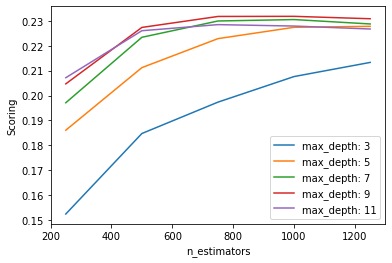

In [146]:
# summarize results
print("Best: %f using %s" % (xgb_grid.best_score_, xgb_grid.best_params_))
means = xgb_grid.cv_results_['mean_test_score']
stds = xgb_grid.cv_results_['std_test_score']
params = xgb_grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))
    
# plot results
scores = np.array(means).reshape(len(n_estimators), len(max_depth))
for i, value in enumerate(max_depth):
    plt.plot(n_estimators, scores[i], label='max_depth: ' + str(value))
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('Scoring')

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_imp, y_imp, test_size=0.2, random_state=1)

In [21]:
model = xgb.XGBRegressor(max_depth=9, learning_rate=0.01, subsample=0.8, n_estimators=1000, base_score=y_train.mean())
# model.fit(X_train, y_train, eval_set=[(X_test,y_test)], eval_metric="rmse", verbose=1000, early_stopping_rounds=20)
model.fit(X_train, y_train)
pred = model.predict(X_test, output_margin=True)
print("Model absolute error =", mean_absolute_error(y_test, pred))
print("Model squared error =", mean_squared_error(y_test, pred))
print("R2% =", r2_score(y_test, pred)*100)

Model absolute error = 2.5685337610030192
Model squared error = 22.437848986661685
R2% = 32.97695422298161


In [22]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

In [23]:
vals = np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(X.columns,vals)),columns=['col_name', 'feature_importance_vals'])

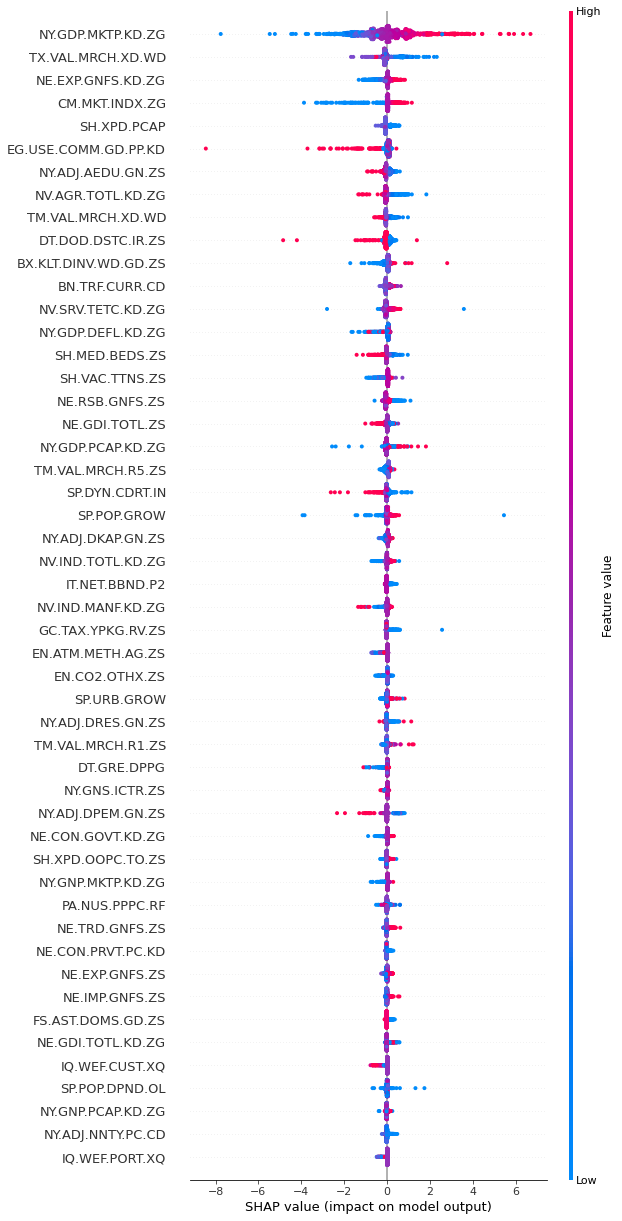

In [24]:
shap.summary_plot(shap_values, X_test, show=False, max_display=50, 
                  feature_names=list(feature_importance['col_name']))

### Kfold cross validation
To provide a more accurate estimation of the performance of the model we make 10 repetitions of a 5-fold cross validation, computing the mean in each repetition and finally providing the mean and the standard deviation of the R2.

In [229]:
res = []
append = res.append
for _ in range(10):
    kf = KFold(n_splits=5, shuffle=True)
    append(np.mean(cross_val_score(model, X_train, y_train, cv=kf, scoring='r2')))

In [230]:
print(res)
print('Mean R2:', np.mean(res), 'Sd R2:', np.std(res))

[0.18936801505504633, 0.15514676821115186, 0.22882340802842763, 0.18278591537248995, 0.1848042735813942, 0.18315799186710163, 0.21267776136981603, 0.19089931751184125, 0.16242930442740153, 0.13065443089045012]
Mean R2: 0.18207471863151203 Sd R2: 0.026490157530089903


### **FINAL MODEL**

In [172]:
X_train, X_test, y_train, y_test = train_test_split(X_imp, y_imp, test_size=0.2, random_state=1)
model.fit(X_train, y_train)
pred = model.predict(X_test, output_margin=True)
print("Model absolute error =", mean_absolute_error(y_test, pred))
print("Model squared error =", mean_squared_error(y_test, pred))
print("R2% =", r2_score(y_test, pred)*100)

Model absolute error = 2.558601700549799
Model squared error = 22.303453206064653
R2% = 32.16783403082755
